# Model fit

We import results form experiments and compare with model, for low Péclet number:

\begin{equation}
    \Phi_0 = c_0 Q \left( 1- \exp\left( - \frac{PL}{QR}\right)\right)
\end{equation}

In [1]:
import numpy as np

from scipy.optimize import root_scalar, curve_fit

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
c0 = 0.2              # µg/µL
PL = np.pi*0.06*1.     # cm²

In [3]:
# µL/min
Qs = np.array([0.1,
               0.3,
               1,
               3,
               10])



folders = [
           ['2022-07-05 0.1 uLpmin', '2022-09-03 0.1 uLpmin', '2022-09-06 0.1 uLpmin'],
           ['2022-09-05 0.3 uLpmin', '2022-09-07 0.3 uLpmin', '2022-09-08 0.3 uLpmin'],
           ['2022-06-30 1 uLpmin', '2022-07-20 1 uLpmin', '2022-09-01 1 uLpmin'],
           ['2022-09-03 3 uLpmin', '2022-09-05 3 uLpmin', '2022-09-08 3 uLpmin'],
           ['2022-07-19 10 uLpmin', '2022-09-02 10 uLpmin', '2022-09-06 10 uLpmin']
          ]

#tends = [1000,
#         1000,
#         1000,
#         800,
#         800,
#         400,
#         100]

## Load files

In [4]:
curves = []

for flow in folders:
    triplicates = []
    averages = []
    for folder in flow:
        # Import
        data = np.loadtxt(f"../{folder}/mass_Abel.txt")
        triplicates.append(data[:,2])
    curves.append(triplicates)

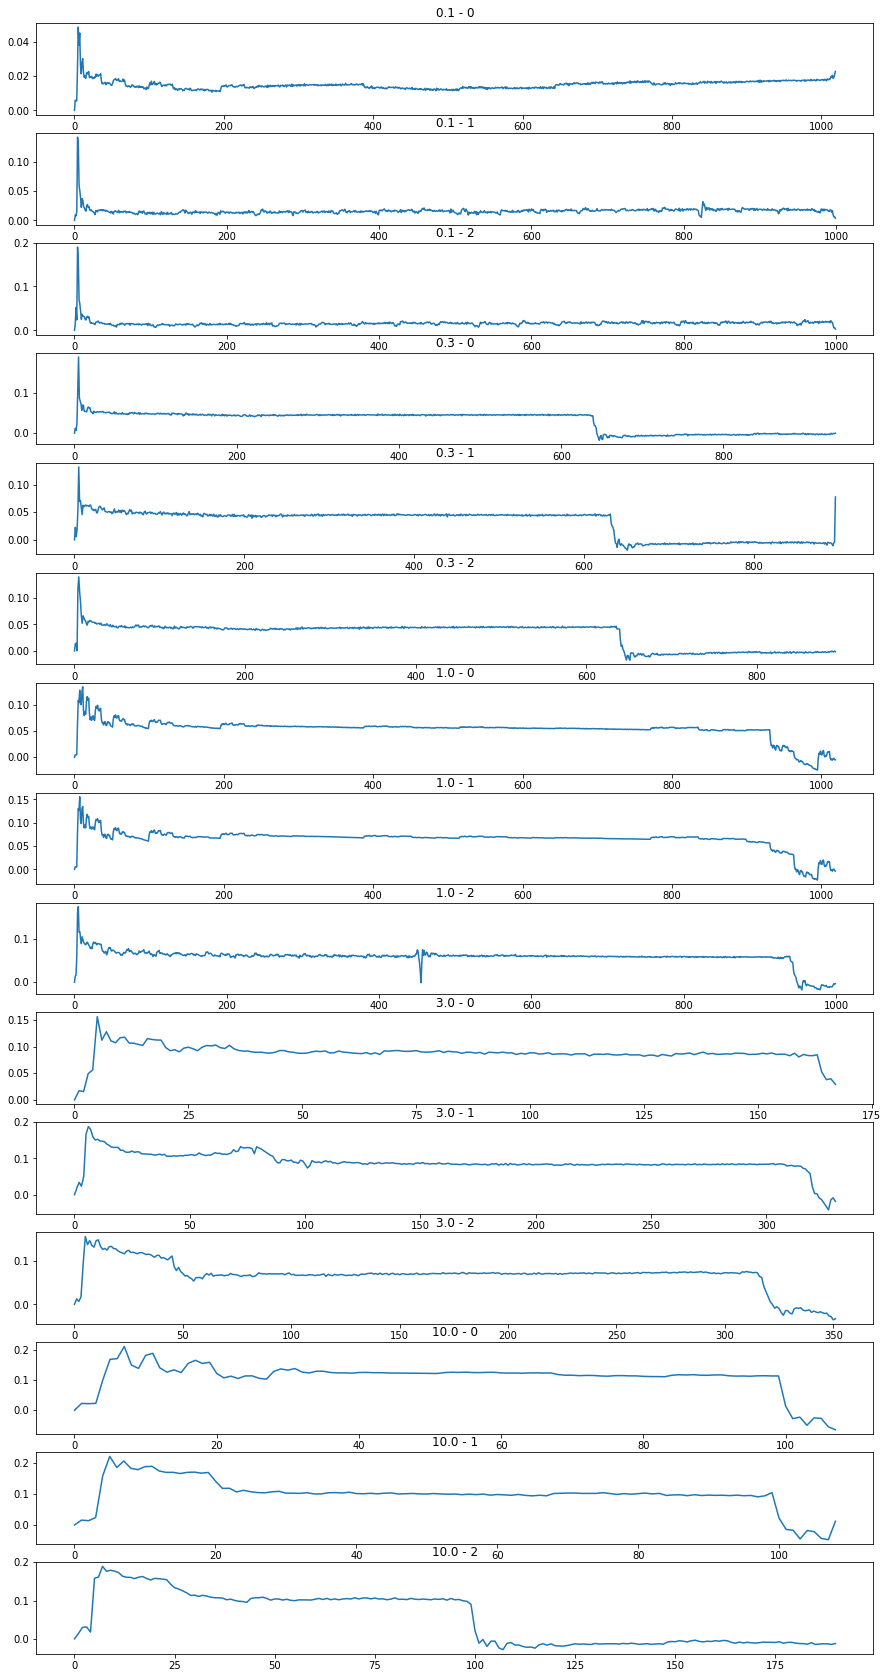

In [5]:
plt.rcParams["figure.figsize"] = (15,30)
figure, ax = plt.subplots(nrows=15)
for i, triplicates in enumerate(curves):
    for j, curve in enumerate(triplicates):
        ax[3*i+j].plot(curve)
        ax[3*i+j].set_title(f"{Qs[i]} - {j}")
plt.show()

In [6]:
# Set limits for averaging the mass flux
limits = [
           [[50, 950], [50, 950], [50, 950]],
           [[50, 600], [50, 600], [50, 600]],
           [[50, 900], [50, 900], [50, 900]],
           [[50, 160], [50, 300], [50, 300]],
           [[30, 95], [30, 95], [30, 95]]
          ]

In [7]:
# Do averages of curves
rates = []
for i, triplicates in enumerate(curves):
    ensemble = []
    for j, curve in enumerate(triplicates):
        ensemble.append(np.average(curve[limits[i][j][0]:limits[i][j][1]]))
    rates.append(ensemble)

# average, min and max of triplicates
rates_avg = []
rates_min = []
rates_max = []

for triplicates in rates:
    rates_avg.append(np.average(triplicates))
    rates_min.append(np.min(triplicates))
    rates_max.append(np.max(triplicates))
rates_avg = np.array(rates_avg)
rates_min = np.array(rates_min)
rates_max = np.array(rates_max)

## Fit model

In [29]:
# Low Péclet number model
Qs_mod = np.logspace(-1,1,100)
R = 0.4

#(R, S), pcov = curve_fit(lambda x, R, S: S*c0*x*(1 - np.exp(-PL/(x*R))), Qs, rates_avg, p0=[0.3, 0.8])
R, pcov = curve_fit(lambda x, R: c0*x*(1 - np.exp(-PL/(x*R))), Qs, rates_avg, p0=0.3, sigma=(rates_max-rates_min)/2)
print(f"Overall resistance: {R[0]} ± {np.sqrt(pcov[0,0])} cm²min/µL")

# Model based on fit
Phis_mod = c0*Qs_mod*(1 - np.exp(-PL/(Qs_mod*R)))
eta_mod = (1 - np.exp(-PL/(Qs_mod*R)))


Overall resistance: 0.4595925712973818 ± 0.05952656269395336 cm²min/µL


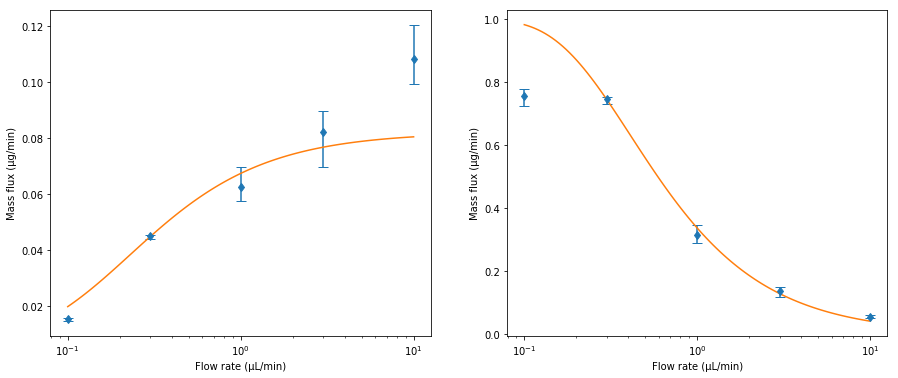

In [19]:
plt.rcParams["figure.figsize"] = (15,6)
figure, ax = plt.subplots(ncols=2)

ax[0].errorbar(Qs, rates_avg, marker='d', yerr=[rates_avg-rates_min, rates_max-rates_avg], capsize=5, ls='none')
ax[0].plot(Qs_mod, Phis_mod)
ax[0].set_xscale("log", nonposx='clip')
ax[0].set_xlabel('Flow rate (µL/min)')
ax[0].set_ylabel('Mass flux (µg/min)')

ax[1].errorbar(Qs, rates_avg/(c0*Qs), marker='d', yerr=[(rates_avg-rates_min)/(c0*Qs), (rates_max-rates_avg)/(c0*Qs)], capsize=5, ls='none')
ax[1].plot(Qs_mod, eta_mod)
ax[1].set_xscale("log", nonposx='clip')
ax[1].set_xlabel('Flow rate (µL/min)')
ax[1].set_ylabel('Mass flux (µg/min)')
plt.show()

In [10]:
# Save for gnuplot
np.savetxt('rates.txt', np.hstack((Qs[:, None], rates_avg[:, None], rates_min[:, None], rates_max[:, None])), header='# Flow (µL/min),  mean mass flux (µg/min), min, max')